# <center>Grupo 29 - CHP2</center>

### Importamos todas las librerías que vamos a necesitar


In [ ]:
!pip install 'dtreeviz'


In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz


from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report


from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

###Utilizamos el dataset normalizado del CHP1


In [ ]:
hotels_tr = pd.read_csv("hoteles_tr_normalizado.csv")

### Análisis exploratorio

mostramos algunas filas del data set

In [ ]:
hotels_tr.head()

Unnamed: 0         hotel   lead_time  arrival_date_year arrival_date_month  \
0           0    City Hotel  112.259683               2016          September   
1           1  Resort Hotel  112.259683               2015            October   
2           2    City Hotel  112.259683               2016            October   
3           3    City Hotel  112.259683               2016           December   
4           4    City Hotel  112.259683               2017              March   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                          5                      1.0                     2   
1                         31                      0.0                     1   
2                         13                      0.0                     1   
3                         12                      2.0                     5   
4                         19                      2.0                     5   

     adults  children  ...  deposit_type   agent company days_in_waiting_list  \
0  1.865199       0.0  ...    No Deposit     9.0 -9999.0                    0   
1  1.865199       0.0  ...    No Deposit -9999.0 -9999.0                    0   
2  1.865199       2.0  ...    No Deposit     9.0 -9999.0                    0   
3  1.865199       0.0  ...    Non Refund   154.0 -9999.0                    0   
4  1.865199       0.0  ...    No Deposit    20.0 -9999.0                    0   

     customer_type         adr  required_car_parking_spaces  \
0        Transient  102.550188                            0   
1        Transient  102.550188                            1   
2        Transient  102.550188                            0   
3        Transient  102.550188                            0   
4  Transient-Party  102.550188                            0   

   total_of_special_requests is_canceled scores  
0                          1           1   -1.0  
1                          0           0   -1.0  
2                          2           0   -1.0  
3                          0           1   -1.0  
4                          1           0   -1.0  

[5 rows x 31 columns]

###Preprocesamiento

#### Modificacion de datos para el analisis *predictivo*

In [ ]:
hotels_tr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61706 entries, 0 to 61705
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      61706 non-null  int64  
 1   hotel                           61706 non-null  object 
 2   lead_time                       61706 non-null  float64
 3   arrival_date_year               61706 non-null  int64  
 4   arrival_date_month              61706 non-null  object 
 5   arrival_date_day_of_month       61706 non-null  int64  
 6   stays_in_weekend_nights         61706 non-null  float64
 7   stays_in_week_nights            61706 non-null  int64  
 8   adults                          61706 non-null  float64
 9   children                        61706 non-null  float64
 10  babies                          61706 non-null  int64  
 11  meal                            61706 non-null  object 
 12  country                         

Trabajamos con los meses como temporada alta "1" y temporada baja "0" para no agregarle tantas variables al ds cuando utilizemos getdummies y en consecuencia tener una mejor prediccion. Por ultimo normalizamos las variables country con pocos valores.

In [ ]:
month_number_in_season = {
    'January': 0,
    'February': 0,
    'March': 0,
    'April': 1,
    'May': 1,
    'June': 1,
    'July': 1,
    'August': 1,
    'September': 1,
    'October': 1,
    'November': 0,
    'December': 0
}
hotels_tr['arrival_date_month'] = hotels_tr['arrival_date_month'].map(month_number_in_season)

dejo los top 10 paises en el dataframe y el resto los agrupo en otros

In [ ]:
country_counts  = hotels_tr["country"].value_counts()

# Obtenemos los 10 países principales
top_10_countries = country_counts.head(10).index

# Reemplazo los países que no están en el top 10 con "otros"
hotels_tr["country"] = hotels_tr["country"].apply(lambda x: x if x in top_10_countries else "otros")

In [ ]:
hotels_tr["country"].value_counts()

PRT      27873
otros     9023
GBR       5723
FRA       4788
ESP       4199
DEU       3303
ITA       1904
IRL       1613
BRA       1150
BEL       1114
USA       1016
Name: country, dtype: int64

In [ ]:
hotels_tr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61706 entries, 0 to 61705
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      61706 non-null  int64  
 1   hotel                           61706 non-null  object 
 2   lead_time                       61706 non-null  float64
 3   arrival_date_year               61706 non-null  int64  
 4   arrival_date_month              61706 non-null  int64  
 5   arrival_date_day_of_month       61706 non-null  int64  
 6   stays_in_weekend_nights         61706 non-null  float64
 7   stays_in_week_nights            61706 non-null  int64  
 8   adults                          61706 non-null  float64
 9   children                        61706 non-null  float64
 10  babies                          61706 non-null  int64  
 11  meal                            61706 non-null  object 
 12  country                         

In [ ]:
variables_categoricas = ["hotel", "arrival_date_month", "meal", "country", "market_segment",
"distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type",
"customer_type", "company", "agent"]

###Entrenamiento y Prediccion

Arboles De Decision


####Tranformacion de datos

Variables Categoricas

es importante tener lo de los dummies aca arriba para que rellene las variables que son strings y no operar con ellas

In [ ]:
#One hot encoding para variables categoricas
hotels_tr = pd.get_dummies(hotels_tr, columns= variables_categoricas, drop_first=True)
hotels_tr.head()

Unnamed: 0   lead_time  arrival_date_year  arrival_date_day_of_month  \
0           0  112.259683               2016                          5   
1           1  112.259683               2015                         31   
2           2  112.259683               2016                         13   
3           3  112.259683               2016                         12   
4           4  112.259683               2017                         19   

   stays_in_weekend_nights  stays_in_week_nights    adults  children  babies  \
0                      1.0                     2  1.865199       0.0       0   
1                      0.0                     1  1.865199       0.0       0   
2                      0.0                     1  1.865199       2.0       0   
3                      2.0                     5  1.865199       0.0       0   
4                      2.0                     5  1.865199       0.0       0   

   is_repeated_guest  ...  agent_493.0  agent_495.0  agent_497.0  agent_502.0  \
0                  0  ...            0            0            0            0   
1                  0  ...            0            0            0            0   
2                  0  ...            0            0            0            0   
3                  0  ...            0            0            0            0   
4                  0  ...            0            0            0            0   

   agent_508.0  agent_509.0  agent_526.0  agent_527.0  agent_531.0  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   agent_535.0  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 639 columns]

####Train - Test

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x=hotels_tr.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = hotels_tr['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

In [ ]:
y_train.head(2)

50149    1
43347    0
Name: is_canceled, dtype: int64

In [ ]:
x_test.head(2)

Unnamed: 0   lead_time  arrival_date_year  arrival_date_day_of_month  \
39347       39480  112.259683               2017                         10   
7884         7908  112.259683               2015                          5   

       stays_in_weekend_nights  stays_in_week_nights    adults  children  \
39347                      1.0                     4  1.865199       0.0   
7884                       2.0                     2  1.865199       0.0   

       babies  is_repeated_guest  ...  agent_493.0  agent_495.0  agent_497.0  \
39347       0                  0  ...            0            0            0   
7884        0                  0  ...            0            0            0   

       agent_502.0  agent_508.0  agent_509.0  agent_526.0  agent_527.0  \
39347            0            0            0            0            0   
7884             0            0            0            0            0   

       agent_531.0  agent_535.0  
39347            0            0  
7884             0            0  

[2 rows x 638 columns]

In [ ]:
y_test.head(2)

39347    0
7884     1
Name: is_canceled, dtype: int64

In [ ]:
#Creo un clasificador
tree_model = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 20,
                                         min_samples_leaf=10)

#Entreno el modelo
model = tree_model.fit(X = x_train, y = y_train)

In [ ]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(x_test)

y_pred

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:

y_test.values

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:

ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head(10)

test  pred
0     0     0
1     1     1
2     1     1
3     1     1
4     0     0
5     0     0
6     1     1
7     1     1
8     1     1
9     1     0

Text(50.722222222222214, 0.5, 'True')

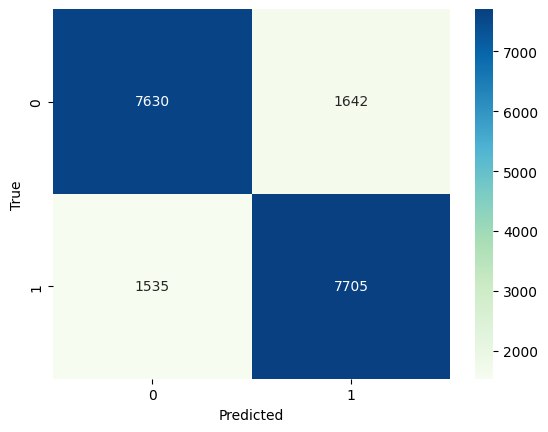

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
#Calculo las métricas
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8283815903197925
Recall: 0.8338744588744589
Precision: 0.8243286616026533
f1 score: 0.8290740840372304


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      9272
           1       0.82      0.83      0.83      9240

    accuracy                           0.83     18512
   macro avg       0.83      0.83      0.83     18512
weighted avg       0.83      0.83      0.83     18512



####Graficamos el arbol

In [ ]:
model.classes_

array([0, 1])

In [ ]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(model,
                                  max_depth=3,#Altura del arbol
                                 feature_names=ds_trabajo_x.columns.to_list(),
                                 filled=True,
                                 rounded=True,
                                 class_names=['not_canceled','is_canceled'])
plt.show(tree_plot_completo)

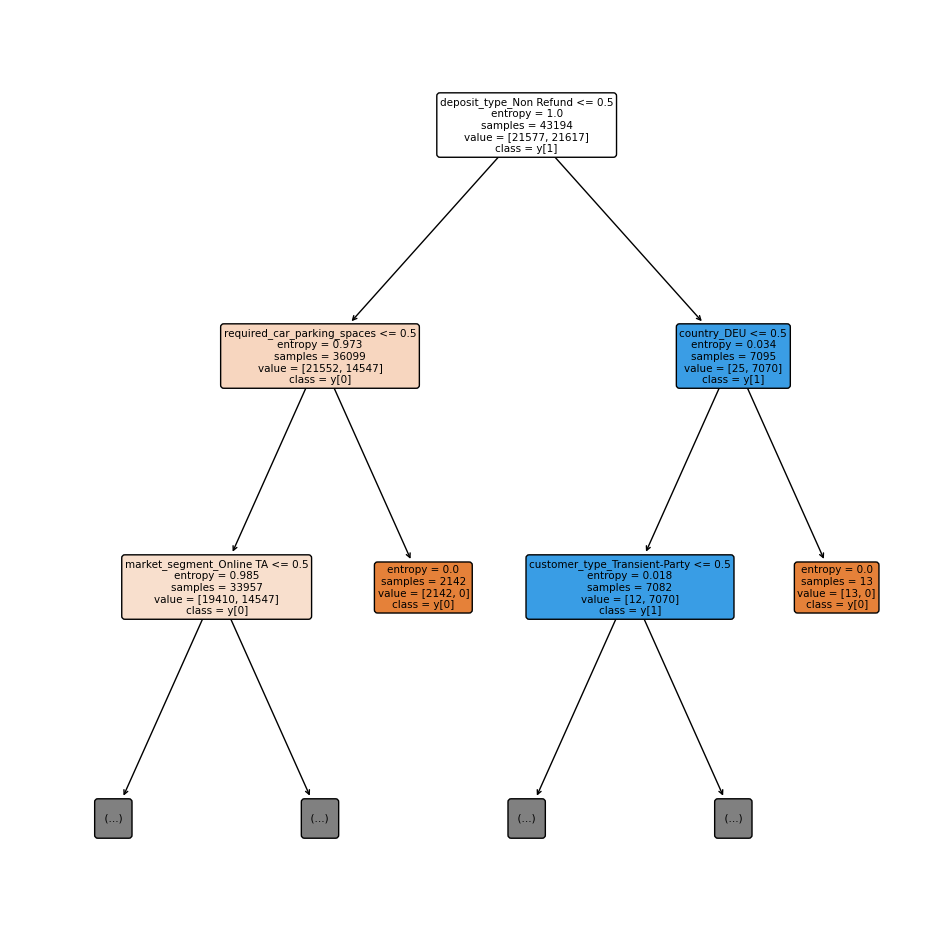

In [ ]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(model,
                         max_depth=2,
                         feature_names=ds_trabajo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

####Importancia de atributos

Segun la documentacion las característica se ordenan de mayor a menor a partir su importancia. <br>
Esto se conoce como la importancia de Gini.<br>


In [ ]:
sorted(list(zip(ds_trabajo_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('deposit_type_Non Refund', 0.2819641260437132),
 ('country_PRT', 0.13592967115324678),
 ('required_car_parking_spaces', 0.05966133202978686),
 ('total_of_special_requests', 0.05088907130881498),
 ('arrival_date_day_of_month', 0.04738544883800891),
 ('market_segment_Online TA', 0.047210234355954665),
 ('Unnamed: 0', 0.04212827180764047),
 ('arrival_date_year', 0.03720741773993372),
 ('stays_in_week_nights', 0.03585492943432558),
 ('previous_cancellations', 0.03293876944811356),
 ('customer_type_Transient', 0.02174116865918808),
 ('stays_in_weekend_nights', 0.018184327860015802),
 ('market_segment_Direct', 0.016016866771267624),
 ('agent_240.0', 0.015598930909751955),
 ('distribution_channel_TA/TO', 0.01473834309142297),
 ('is_repeated_guest', 0.014377390663598317),
 ('agent_7.0', 0.014337415608275249),
 ('booking_changes', 0.01284794437005113),
 ('agent_9.0', 0.01250517834835355),
 ('arrival_date_month_1', 0.009397568956804847),
 ('agent_17.0', 0.007898580502811439),
 ('hotel_Resort H

####Poda

Realizamos una poda debido a la gran cantidad de datos que no ayudan a la prediccion. <pr>

Corta hojas chequiando que la metrica de error mejore. <pr>

A medida que aumenta el alfa, se poda una mayor parte del árbol, lo que aumenta la impureza total de sus hojas.<pr>

In [ ]:
#Creo un clasificador
arbol_poda = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 10,
                                         min_samples_leaf=9,
                                         ccp_alpha=0.03)
#Entreno un modelo
model_poda = arbol_poda.fit(X = x_train, y = y_train)

#Hago una predicción
y_pred_poda = model_poda.predict(x_test)

#Visualizo los resultados en un dataframe
ds_resultados_poda=pd.DataFrame(zip(y_test,y_pred_poda),columns=['test','pred'])
ds_resultados_poda.head(10)

test  pred
0     0     0
1     1     1
2     1     1
3     1     0
4     0     0
5     0     0
6     1     1
7     1     1
8     1     1
9     1     1

Text(50.722222222222214, 0.5, 'True')

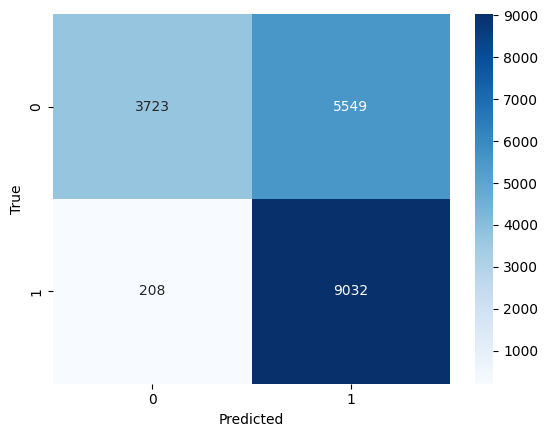

In [ ]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_poda)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
#Performance
accuracy_poda=accuracy_score(y_test,y_pred_poda)
recall_poda=recall_score(y_test,y_pred_poda)
f1_poda=f1_score(y_test,y_pred_poda)

print("Accuracy: "+str(accuracy_poda))
print("Recall: "+str(recall_poda))
print("f1 score: "+str(f1_poda))

Accuracy: 0.6890125324114088
Recall: 0.9774891774891775
f1 score: 0.7583224885605139


In [ ]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(model_poda,
                                 feature_names=ds_trabajo_x.columns.to_list(),
                                 filled=True,
                                 rounded=True)
plt.show(tree_plot_completo)

###Feature Engineering


In [ ]:
ds_trabajo_fe=hotels_tr.copy()

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_fe_x=ds_trabajo_fe.drop(['is_canceled'], axis='columns', inplace=False)


ds_trabajo_fe_y = ds_trabajo_fe['is_canceled'].copy()

x_fe_train, x_fe_test, y_fe_train, y_fe_test = train_test_split(ds_trabajo_fe_x,
                                                                ds_trabajo_fe_y,
                                                                test_size=0.3,  #proporcion 70/30
                                                                random_state=2) #semilla

In [ ]:

scaler = MinMaxScaler()


scaler.fit(pd.DataFrame(x_fe_train['stays_in_weekend_nights']))

print(scaler.data_max_)
print(scaler.data_min_)

[6.]
[0.]


In [ ]:
sorted(ds_trabajo_fe.stays_in_weekend_nights)[0:20]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
x_fe_train['stays_in_weekend_nights']

50149    2.0
43347    1.0
26566    1.0
32782    2.0
55874    3.0
        ... 
44566    0.0
30280    2.0
6637     2.0
35343    0.0
23720    0.0
Name: stays_in_weekend_nights, Length: 43194, dtype: float64

In [ ]:

tree_model_fe = tree.DecisionTreeClassifier(criterion="entropy",
                                            max_depth = 20,
                                            min_samples_leaf=10,
                                            ccp_alpha=0.01)
#Entreno un modelo
model_fe = tree_model_fe.fit(X = x_fe_train, y = y_fe_train)

#Hago una prediccion
y_pred_fe = model_fe.predict(x_fe_test)

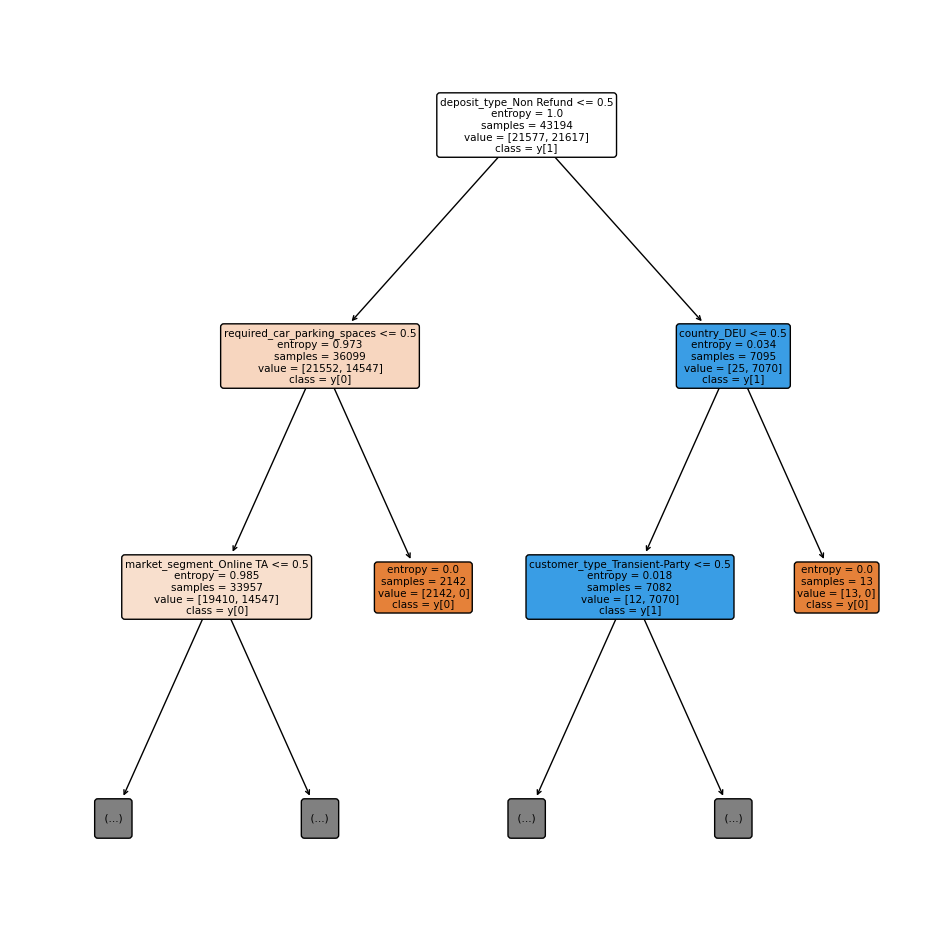

In [ ]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(model,
                         max_depth=2,
                         feature_names=ds_trabajo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

In [ ]:
#Evaluamos la performance en el conjunto de evaluación
accuracy_fe=accuracy_score(y_test, y_pred_fe)

recall_fe=recall_score(y_test, y_pred_fe )

f1_fe=f1_score(y_test, y_pred_fe)

print("Accuracy: "+str(accuracy_poda))
print("Recall: "+str(recall_poda))
print("f1 score: "+str(f1_fe))

Accuracy: 0.6890125324114088
Recall: 0.9774891774891775
f1 score: 0.7121466293880088


###Hiperparametros
K fold - Cross Validation

In [ ]:
hotels_tr.head()

Unnamed: 0   lead_time  arrival_date_year  arrival_date_day_of_month  \
0           0  112.259683               2016                          5   
1           1  112.259683               2015                         31   
2           2  112.259683               2016                         13   
3           3  112.259683               2016                         12   
4           4  112.259683               2017                         19   

   stays_in_weekend_nights  stays_in_week_nights    adults  children  babies  \
0                      1.0                     2  1.865199       0.0       0   
1                      0.0                     1  1.865199       0.0       0   
2                      0.0                     1  1.865199       2.0       0   
3                      2.0                     5  1.865199       0.0       0   
4                      2.0                     5  1.865199       0.0       0   

   is_repeated_guest  ...  agent_493.0  agent_495.0  agent_497.0  agent_502.0  \
0                  0  ...            0            0            0            0   
1                  0  ...            0            0            0            0   
2                  0  ...            0            0            0            0   
3                  0  ...            0            0            0            0   
4                  0  ...            0            0            0            0   

   agent_508.0  agent_509.0  agent_526.0  agent_527.0  agent_531.0  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   agent_535.0  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 639 columns]

In [ ]:
#veo el porcentaje de cancelaciones y de no cancelaciones
hotels_tr.is_canceled.value_counts(normalize= True)*100

1    50.006482
0    49.993518
Name: is_canceled, dtype: float64

In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

#Cantidad de combinaciones que quiero porbar
n=50

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,5)),
               'min_samples_split': list(range(2,10)),
               'ccp_alpha':np.linspace(0,0.01,n),
               'max_depth':list(range(12,17))}


#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 15, 'criterion': 'entropy', 'ccp_alpha': 0.00020408163265306123}
0.83266608691878


In [ ]:
hotels_tr.columns

Index(['Unnamed: 0', 'lead_time', 'arrival_date_year',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest',
       ...
       'agent_493.0', 'agent_495.0', 'agent_497.0', 'agent_502.0',
       'agent_508.0', 'agent_509.0', 'agent_526.0', 'agent_527.0',
       'agent_531.0', 'agent_535.0'],
      dtype='object', length=639)

In [ ]:
randomcv.cv_results_['mean_test_score']

array([0.78057904, 0.76261043, 0.77994383, 0.78399125, 0.73160316,
       0.74206894, 0.80893701, 0.74685292, 0.80905836, 0.82308886,
       0.7500165 , 0.71359469, 0.71359469, 0.72975628, 0.78063483,
       0.75139293, 0.80505991, 0.75992074, 0.77654935, 0.77994383,
       0.74206894, 0.77654935, 0.74206894, 0.78367936, 0.72975628,
       0.74685292, 0.74685292, 0.82781308, 0.80904995, 0.74206894,
       0.7500165 , 0.80145327, 0.82087276, 0.81179682, 0.77654935,
       0.72970413, 0.82186691, 0.76261043, 0.80505991, 0.71359469,
       0.71872615, 0.71359469, 0.68296926, 0.82462474, 0.76907852,
       0.81367913, 0.68296926, 0.83266609, 0.74206894, 0.74206894])

In [ ]:
features = ['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests']

In [ ]:
#Atributos considerados y su importancia
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

days_in_waiting_list: 0.0005257718022227418
required_car_parking_spaces: 0.0005743752966671703
deposit_type: 0.0006061159787358057
stays_in_week_nights: 0.0008138476162537477
booking_changes: 0.00089671429264912
hotel: 0.0009475325534058996
total_of_special_requests: 0.0009639422083151848
customer_type: 0.001247649693193225
agent: 0.0015526675513613016
market_segment: 0.0022264420603466772
reserved_room_type: 0.0025346248759143958
adr: 0.004757428810769352
assigned_room_type: 0.005059251911486283
arrival_date_week_number: 0.00819778011626832
arrival_date_month: 0.008379127407758926
country: 0.011476415004114147
children: 0.01579767232489651
arrival_date_day_of_month: 0.02751702378504354
arrival_date_year: 0.03785043922812285
babies: 0.03984413716292434
previous_cancellations: 0.05713219307142386
is_repeated_guest: 0.07050495748844685


#### Predicción y Evaluación del Modelo

Con mejores hiperparametros

In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol = DecisionTreeClassifier().set_params(**randomcv.best_params_)

#vuelvo a Entrenar el arbol en todo el set con mejores parametros
arbol.fit(x_train,y_train) #obtenemos los parametros optimos del modelo


DecisionTreeClassifier(ccp_alpha=0.00020408163265306123, criterion='entropy',
                       max_depth=15, min_samples_leaf=3, min_samples_split=8)

graficamos nuestro mejor arbol

F1-Score: 0.8379227696404793


Text(50.722222222222214, 0.5, 'True')

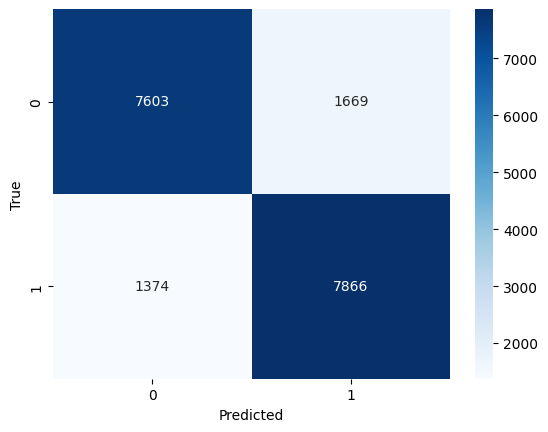

In [ ]:
#Evalúo el Arbol con los mejores hiperparámetros
from sklearn.metrics import confusion_matrix, classification_report , f1_score

#Hago predicción sobre el set de evaluacion
y_pred= arbol.predict(x_test)

#Arbol Reporte y Matriz de Confusion

print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
hotels_tr.shape

(61706, 639)

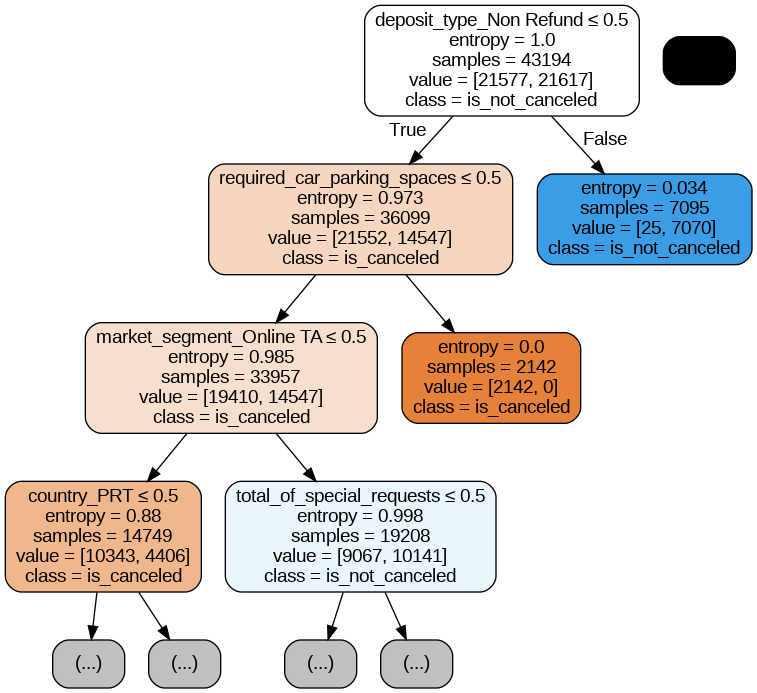

In [ ]:
from six import StringIO

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
#Grafico
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
                filled=True, rounded=True, max_depth=3,
                special_characters=True,
                feature_names=ds_trabajo_x.columns.to_list(),
                class_names=['is_canceled','is_not_canceled'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
arbol.predict_proba(x_test)

array([[9.99253360e-01, 7.46640119e-04],
       [1.51975684e-03, 9.98480243e-01],
       [1.02493075e-01, 8.97506925e-01],
       ...,
       [8.09264305e-01, 1.90735695e-01],
       [9.53771290e-01, 4.62287105e-02],
       [0.00000000e+00, 1.00000000e+00]])

###Pre Procesamiento de Datos de hotel_train

In [ ]:
ds_hotels_test = pd.read_csv("hotels_test.csv")
ds_h_test = ds_hotels_test.copy()

In [ ]:
filas_totales=ds_hotels_test.shape[0]
print(ds_h_test.isna().sum()/filas_totales*100)

hotel                              0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.000000
babies                             0.000000
meal                               0.000000
country                            0.358018
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                       0.000000
agent                           

In [ ]:
month_number_in_season = {
    'January': 0,
    'February': 0,
    'March': 0,
    'April': 1,
    'May': 1,
    'June': 1,
    'July': 1,
    'August': 1,
    'September': 1,
    'October': 1,
    'November': 0,
    'December': 0
}

ds_h_test['arrival_date_month'] = ds_h_test['arrival_date_month'].map(month_number_in_season)

In [ ]:
country_counts  = ds_h_test["country"].value_counts()

# Obtenemos los 10 países principales
top_10_countries = country_counts.head(10).index

# Reemplazo los países que no están en el top 10 con "otros"
ds_h_test["country"] = ds_h_test["country"].apply(lambda x: x if x in top_10_countries else "otros")

In [ ]:
ds_h_test['agent'] = ds_h_test['agent'].fillna(-9999, inplace=True)

In [ ]:
ds_h_test.isna().any()


hotel                             False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                              True
company                            True
days_in_waiting_list              False


In [ ]:
ds_h_test.isin(['Undefined']).sum()

hotel                               0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            0
babies                              0
meal                              238
country                             0
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
agent                               0
company                             0
days_in_waiting_list                0
customer_type                       0
adr         

In [ ]:
#One hot encoding para variables categoricas
var_cual = ["hotel", "arrival_date_month", "meal", "country", "market_segment",
"distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "agent",
"customer_type"]
ds_h_test = pd.get_dummies(ds_h_test, columns=var_cual, drop_first=True)

ds_h_test.head()

lead_time  arrival_date_year  arrival_date_week_number  \
0        277               2016                        46   
1        286               2016                        20   
2          0               2016                        35   
3        196               2016                        44   
4        232               2016                        48   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                          7                        1                     2   
1                         11                        0                     4   
2                         23                        0                     1   
3                         29                        2                     5   
4                         26                        2                     1   

   adults  children  babies  is_repeated_guest  ...  assigned_room_type_G  \
0       2       0.0       0                  0  ...                     0   
1       2       0.0       0                  0  ...                     0   
2       3       0.0       0                  0  ...                     0   
3       2       2.0       0                  0  ...                     1   
4       2       0.0       0                  0  ...                     0   

   assigned_room_type_H  assigned_room_type_I  assigned_room_type_K  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   assigned_room_type_P  deposit_type_Non Refund  deposit_type_Refundable  \
0                     0                        1                        0   
1                     0                        0                        0   
2                     0                        0                        0   
3                     0                        0                        0   
4                     0                        1                        0   

   customer_type_Group customer_type_Transient  customer_type_Transient-Party  
0                    0                       1                              0  
1                    0                       0                              1  
2                    0                       1                              0  
3                    0                       1                              0  
4                    0                       1                              0  

[5 rows x 68 columns]

In [ ]:
print(ds_h_test.isna().sum()/filas_totales*100)

lead_time                        0.0
arrival_date_year                0.0
arrival_date_week_number         0.0
arrival_date_day_of_month        0.0
stays_in_weekend_nights          0.0
                                ... 
deposit_type_Non Refund          0.0
deposit_type_Refundable          0.0
customer_type_Group              0.0
customer_type_Transient          0.0
customer_type_Transient-Party    0.0
Length: 68, dtype: float64


In [ ]:
diff_cols_df2 = set(hotels_tr.columns) - set(ds_h_test.columns)

# Agrego las columnas faltantes en ds_h_test y las inicializo en false
for col in diff_cols_df2:
    ds_h_test[col] = np.False_

# Solo me quedo con las columnas de ds_h_test que esten en ds
df_test = ds_h_test[hotels_tr.columns]

<ipython-input-858-9901eeb3fa34>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<ipython-input-858-9901eeb3fa34>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<ipython-input-858-9901eeb3fa34>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<ipython-input-858-9901eeb3fa34>:6: PerformanceWarning: DataF

In [ ]:
ds_kag = df_test.drop(["is_canceled"], axis="columns", inplace=True)

<ipython-input-859-df99e7b4dcc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
pipeline = Pipeline([  ('imputer', imputer)])
pipeline.fit(hotels_tr)

# Obtener lista de columnas de ds
cols_ds = hotels_tr.columns

# Seleccionar solo las columnas presentes en ds en ds_h_test
cols_ds_h_test = [col for col in df_test.columns if col in cols_ds]

# Aplicar pipeline solo a las columnas presentes en ambos dataframes
pipeline.fit(hotels_tr[cols_ds_h_test])
df_test[cols_ds_h_test] = pipeline.transform(df_test[cols_ds_h_test])

<ipython-input-860-b596b527be05>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
y_pred_kaggle = arbol.predict(df_test)

In [ ]:
ds_kaggle = pd.DataFrame({'id': ds_h_test['id'], 'is_canceled': y_pred_kaggle})

In [ ]:
ds_kaggle.shape[0]

26535

In [ ]:
ds_kaggle.to_csv('pred_kaggle.csv', index=False)

###Guardo el Arbol

In [ ]:
#Creamos un clasificador con hiperparámetros
tree_model = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 15,
                                         min_samples_leaf=9,
                                         ccp_alpha=0.01)
#Entrenamos el modelo
model = tree_model.fit(X = x_train, y = y_train)

In [ ]:
# Guardar el arbol
import joblib
filename = 'arbol_chk2.sav'
joblib.dump(model, filename)

['arbol_chk2.sav']

In [ ]:
# Cargar el arbol
loaded_model = joblib.load(filename)
result = loaded_model.score(x_test, y_test)
print(result)

0.7497299049265341


F1-Score: 0.7121466293880088
Accuracy: 0.7497299049265341
Recall: 0.6202380952380953
Precision: 0.8360320933625092


Text(50.722222222222214, 0.5, 'True')

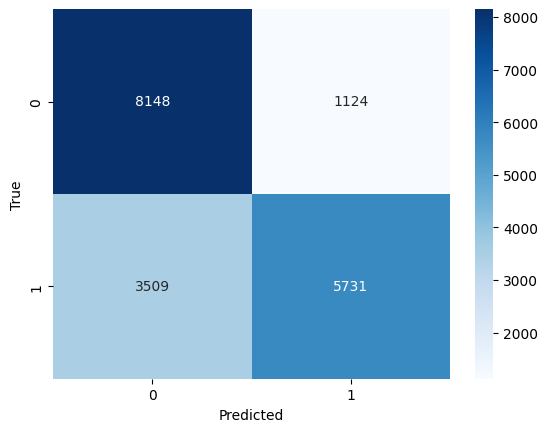

In [ ]:
#Hago predicción sobre el set de evaluacion
y_pred = model.predict(x_test)

#Calculo las métricas en el conjunto de evaluación
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

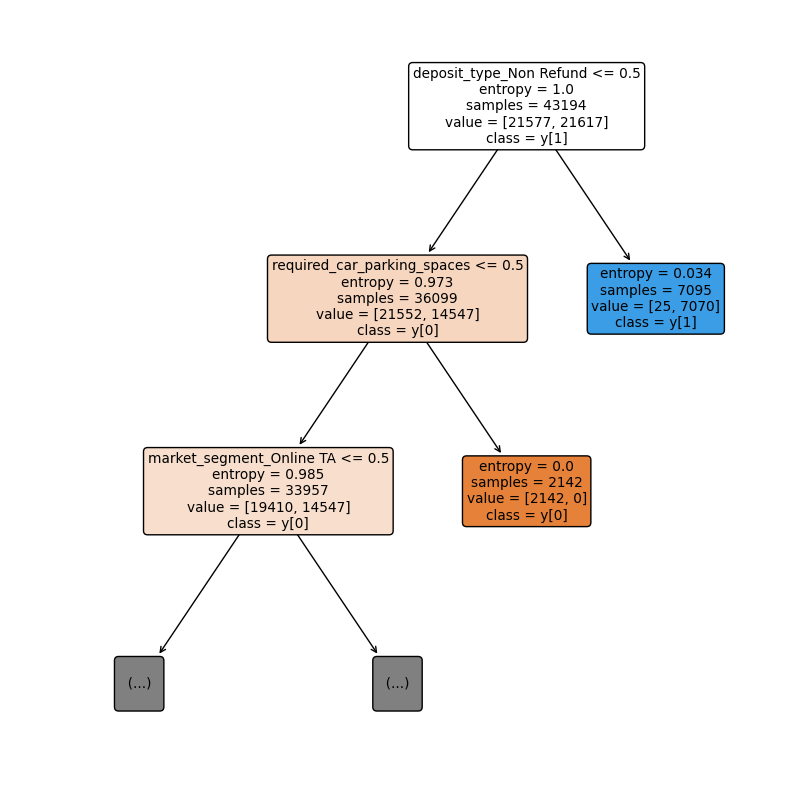

In [ ]:
plt.figure(figsize=(10,10))

tree_plot=tree.plot_tree(model,
                         max_depth=2,
                         feature_names=ds_trabajo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

In [ ]:
features = ['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests']

In [ ]:
feat_imps = model.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

babies: 0.029772059933845484
previous_cancellations: 0.0762730266564206
is_repeated_guest: 0.10886752803780667
